In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Config.data_path()/'atlas'
path.mkdir(exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/atlas')

In [4]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/atlas/test_combined'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/test_all'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train_combined'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train_all'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/models'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/sample_submission.csv'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train.csv')]

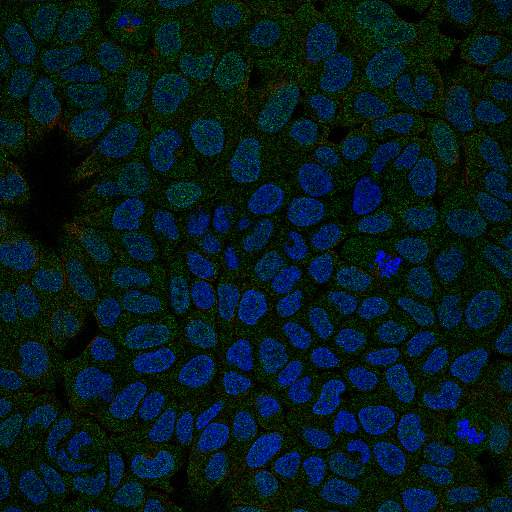

In [5]:
open_image(path/'train_combined/79a6b502-bbb4-11e8-b2ba-ac1f6b6435d0.png')

In [6]:
df = pd.read_csv(path/'train.csv')

In [7]:
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
df.Id.nunique()

31072

In [48]:
df.loc[df['Id'] == '002679c2-bbb6-11e8-b2ba-ac1f6b6435d0']

,Id,Target
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0


In [10]:
sample_subm = pd.read_csv(path/'sample_submission.csv')

In [11]:
sample_subm.Id.nunique()

11702

In [12]:
sample_subm.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [13]:
# tere are no same test and train labels 
set(sample_subm.Id).intersection(df.Id)

set()

### Labels 

0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings  

### Data Preparation

In [14]:
np.random.seed(42)

In [15]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [17]:
bs = 64

In [16]:
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train.csv', sep=' ', folder='train_combined', suffix='.png')  
       .random_split_by_pct(0.2)
       .add_test_folder('test_combined'))

In [18]:
data = (src.datasets()
        .transform(tfms, size=128)
        .databunch(bs=bs).normalize(imagenet_stats))

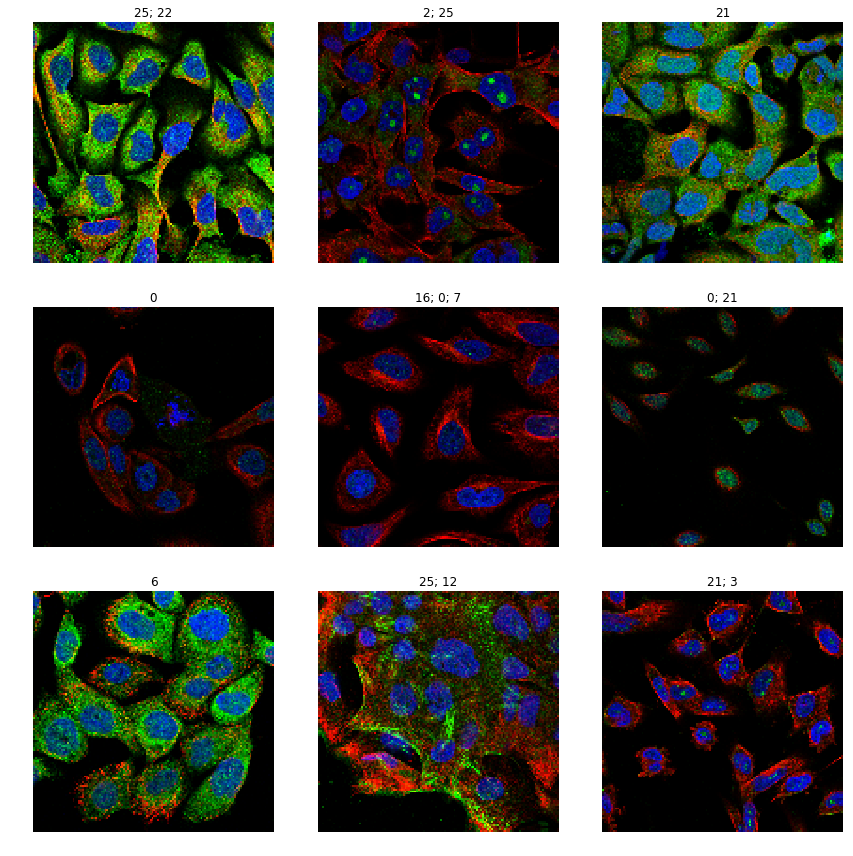

In [24]:
data.show_batch(rows=3, figsize=(12,12))

In [25]:
data.train_ds.ds[1]

(Image (3, 512, 512),
 array([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [26]:
data.train_ds.ds.x[1]

PosixPath('/home/ubuntu/.fastai/data/atlas/train_combined/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.png')

In [27]:
data.train_ds.ds.y[1]

array([2, 3, 4, 1])

In [28]:
data.train_ds.ds.classes

['16',
 '0',
 '7',
 '1',
 '2',
 '5',
 '18',
 '23',
 '21',
 '24',
 '6',
 '25',
 '11',
 '3',
 '12',
 '13',
 '14',
 '4',
 '20',
 '22',
 '17',
 '19',
 '8',
 '9',
 '10',
 '26',
 '27',
 '15']

In [29]:
arch = models.resnet34

In [30]:
f1_score = partial(fbeta, thresh=0.2, beta=1)
learn = create_cnn(data, arch, metrics=f1_score)

In [31]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


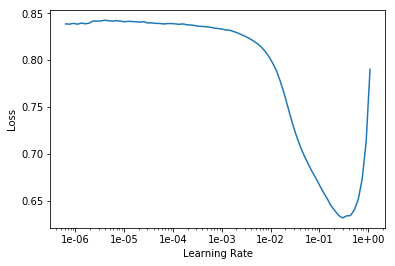

In [32]:
learn.recorder.plot()

In [33]:
lr = 3e-2

In [34]:
learn.fit_one_cycle(5, slice(lr))

Total time: 12:15
epoch  train_loss  valid_loss  fbeta   
1      0.157846    0.153354    0.404340  (02:27)
2      0.160067    0.153227    0.418650  (02:26)
3      0.151276    0.144854    0.447739  (02:27)
4      0.138590    0.135870    0.494919  (02:27)
5      0.134237    0.131271    0.515389  (02:26)



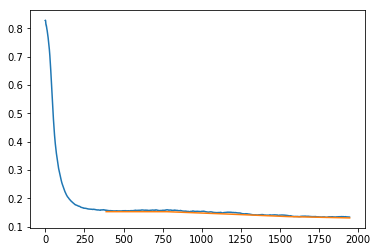

In [35]:
learn.recorder.plot_losses()

In [36]:
learn.save('stage-1-rn34-128')

In [48]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


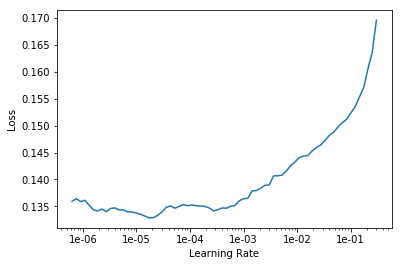

In [49]:
learn.lr_find()
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 12:37
epoch  train_loss  valid_loss  fbeta   
1      0.135877    0.171391    0.500793  (02:31)
2      0.135879    0.149309    0.507423  (02:31)
3      0.136697    0.135648    0.511517  (02:30)
4      0.132645    0.148646    0.510670  (02:30)
5      0.134186    0.177199    0.511131  (02:32)



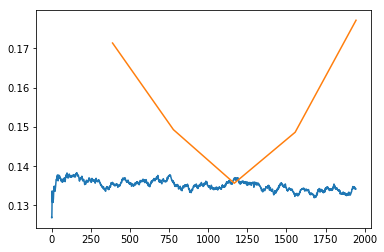

In [65]:
learn.recorder.plot_losses()

In [67]:
learn.fit_one_cycle(5, slice(1e-6, 1e-3))

Total time: 13:26
epoch  train_loss  valid_loss  fbeta   
1      0.132761    0.132556    0.509538  (02:32)
2      0.134808    0.202711    0.513994  (02:32)
3      0.133136    0.135226    0.518063  (02:51)
4      0.132225    0.135352    0.524921  (02:37)
5      0.129740    0.130158    0.522676  (02:52)



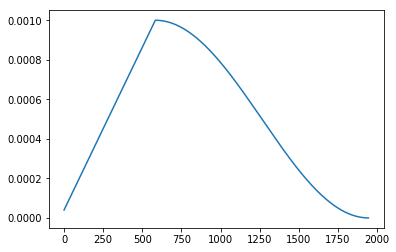

In [69]:
learn.recorder.plot_lr()

In [70]:
learn.save('stage-2-rn34-128')

### Predict 

In [37]:
preds, target_values =  learn.get_preds(DatasetType.Valid)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [38]:
fbeta(preds, target_values, beta=1, thresh=0.2)

tensor(0.1088)

In [78]:
# learn.data = (src.add_test_folder('test_combined')
#         .datasets()
#         .transform(tfms, size=128)
#         .databunch().normalize(imagenet_stats))

In [49]:
preds, _ = learn.get_preds(DatasetType.Test)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [50]:
def get_image_names(data):
    return [fn.stem for fn in data.test_dl.x]

In [51]:
test_ids = get_image_names(learn.data)

In [53]:
# sanity check
set(test_ids).difference(sample_subm.Id.unique())

set()

In [72]:
def get_tags(predictions, data):
    return [" ".join(data.test_ds.ds.classes[i] for i,el in enumerate(predictions[j] > 0.5) if el==1)
            for j in range(len(predictions))]

In [73]:
tags = get_tags(preds, learn.data)

In [74]:
tags[:10]

['0', '', '', '2', '0', '11', '25', '', '', '0 25']

In [75]:
submit_df = pd.DataFrame(data={'Id':test_ids, 'Predicted': tags})

In [76]:
submit_df.shape

(11702, 2)

In [77]:
submit_df.head()

,Id,Predicted
0,54332072-bacd-11e8-b2b8-ac1f6b6435d0,0
1,852a3012-bad7-11e8-b2b9-ac1f6b6435d0,
2,19bc4e2e-bad1-11e8-b2b8-ac1f6b6435d0,
3,1f538b56-bad9-11e8-b2b9-ac1f6b6435d0,2
4,cea42bf0-bacb-11e8-b2b8-ac1f6b6435d0,0


In [78]:
all(submit_df.Id.sort_values().values == sample_subm.Id.values)

True

In [79]:
submit_df.sort_values(by='Id', inplace=True)

In [80]:
all(submit_df.Id.values == sample_subm.Id.values)

True

In [81]:
os.makedirs('data/submits', exist_ok=True)

In [82]:
submit_df.to_csv('data/submits/p1-1-rn-34-128.csv', header=True, index=False)